In [1]:
import warnings
warnings.filterwarnings('ignore')

class TimeSeries: 
    
    def __init__(self, df, feature,train_test_split=0.03):
        self.df=df
        self.feature=feature
        self.x=train_test_split
        
    def analysis(self):
        import seaborn as sns
        import matplotlib.pyplot as plt
        import numpy as np
        from scipy.stats import norm, kurtosis
        import pandas as pd
        
        sns.boxplot(x=self.feature,data=self.df).set_title("Box-Plot before preprocessing")
        mean = self.df[self.feature].mean()  
        sd = self.df[self.feature].std()
        final_list = [x for x in list(self.df[self.feature]) if (x > mean - 3 * sd) and (x < mean + 3 * sd)]
        percentage_outlier=100*(len(final_list)/len(self.df))
        print("Percentage of the observed values in the interval ( -3*Sample SD, +3*SD)=",
              percentage_outlier,"\n")
        print("Kurtosis: ",kurtosis(np.array(self.df[self.feature]),fisher=True),"\n")
        print("Skewness: ",self.df[self.feature].skew(),"\n")
        missing_values = self.df[list(self.df.columns)].isna().sum()
        missing_values_percentage = self.df[list(self.df.columns)].isna().sum().div(len(self.df))
        print("Missing Value: ",missing_values, " Missing Value Percentage: ",missing_values_percentage,"\n")
        print("Summary: \n", self.df.describe(),"\n")
              
    def outlier_cap(self):
        import seaborn as sns
        from feature_engine.outliers import Winsorizer
        capper = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=[self.feature])
        capper.fit(self.df)

        # transform the data
        self.df= capper.transform(self.df)
        sns.boxplot(x=self.feature,data=self.df).set_title("Box-Plot after preprocessing")
              
    def drop_missing_value(self):
        self.df=self.df.dropna()
    
    def train_test_split(self):
        self.train=self.df.iloc[0:-int((self.x)*(len(self.df))),:]
        self.test=self.df.iloc[-int((self.x)*(len(self.df))):,:]
        print("test data shape ",self.test.shape,'\n')
        print("train data shape",self.train.shape,'\n')
              
    def plot_data(self):
        self.df.plot(figsize=(18,8))
    
    def _check_stationarity(df):
        from arch.unitroot import ADF
        adf = ADF(df)
        print("ADF \n", adf.summary().as_text())
        from arch.unitroot import PhillipsPerron
        pp = PhillipsPerron(df)
        print("PP test \n",pp.summary().as_text())
        from arch.unitroot import KPSS
        kpss = KPSS(df)
        print("KPSS Test \n",kpss.summary().as_text())
    
    def _difference(df):
        import matplotlib.pyplot as plt
        df_diff = df - df.shift()
        plt.figure(figsize=(22,10))
        plt.plot(df_diff)
        df_diff.dropna(inplace=True)
        TimeSeries._check_stationarity(df_diff)
        return df_diff
    
    def check_stationarity(self):
        TimeSeries._check_stationarity(self.df)
              
    def difference(self,n=0):
        self.data_dict={0:self.df}
        for i in range(n):
            print("\n Order of Difference: ",i+1,'\n')
            self.data_dict[i+1]=TimeSeries._difference(self.data_dict[i])
    
    def ACF_PACF(self,difference=0):
        # ACF and PACF      
        from statsmodels.tsa.stattools import acf, pacf
        import matplotlib.pyplot as plt
        import numpy as np
        
        ts_diff=self.data_dict[difference]
        lag_acf = acf(ts_diff, nlags=20)
        lag_pacf = pacf(ts_diff, nlags=20, method='ols')
        
        # ACF
        plt.figure(figsize=(26,12))
        plt.subplot(121) 
        plt.plot(lag_acf,marker="o")
        plt.axhline(y=0,linestyle='--',color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
        plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
        plt.title('Autocorrelation Function')

        # PACF
        plt.subplot(122)
        plt.plot(lag_pacf,marker="o")
        plt.axhline(y=0,linestyle='--',color='gray')
        plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
        plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
    
    def auto_arima(self,difference=None,information_criteria='aic'):
        from pmdarima import auto_arima
        stepwise_fit = auto_arima(self.df[self.feature], trace=True,
        suppress_warnings=True,d=difference,information_criterion=information_criteria)
        print(stepwise_fit.summary())
    
    def fit_predict(self,p=1,d=0,q=1):
        import warnings
        warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
        warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
        import pandas as pd
        from statsmodels.tsa.arima_model import ARIMA
        model=ARIMA(self.train[self.feature],order=(p,d,q))
        model=model.fit()
        print(model.summary())
        start=len(self.train)
        end=len(self.train)+len(self.test)-1
        self.pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
        self.pred.index=self.test.index
        self.pred.plot(legend=True,marker='o')
        self.test[self.feature].plot(legend=True,marker='o')
        
    def MSE(self):
        from sklearn.metrics import mean_squared_error
        from math import sqrt
        rmse=sqrt(mean_squared_error(self.pred,self.test[self.feature]))
        print("Mean Squared Error: ",rmse)
        print("Mean of the test dataset: ", self.test[self.feature].mean())

# Importing the Dataset

#### This is a sales timeseries dataset. It has monthly data from year 1972 to 1984. 

In [2]:
import pandas as pd
df=pd.read_csv("sales.csv",index_col='Month',parse_dates=True)
Time_series_df=pd.DataFrame(df['Sales_k'])
ts=TimeSeries(Time_series_df,'Sales_k',train_test_split=0.05)

In [3]:
Time_series_df

,Sales_k
Month,
1972-01-01,580
1972-02-01,610
1972-03-01,630
1972-04-01,670
1972-05-01,710
...,...
1984-08-01,850
1984-09-01,830
1984-10-01,800


# Analysis

After importing the dataset we perform basic analsysis on the data like the percentage of outlier, missing values, skewness, kurtosis and the basic summary. We also plot the box plot of the dataset tto see whether we need to cap any outlier. 

Percentage of the observed values in the interval ( -3*Sample SD, +3*SD)= 100.0 

Kurtosis:  -0.7504746520127976 

Skewness:  0.07064061246052872 

Missing Value:  Sales_k    0
dtype: int64  Missing Value Percentage:  Sales_k    0.0
dtype: float64 

Summary: 
           Sales_k
count  156.000000
mean   747.051282
std     98.578398
min    560.000000
25%    677.500000
50%    750.000000
75%    820.000000
max    960.000000 



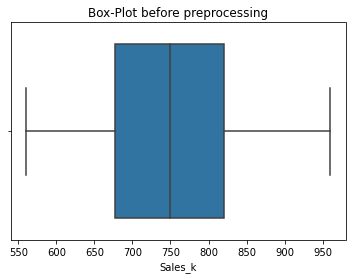

In [4]:
ts.analysis()

# Preprocessing

So there is no missing value present, also no outlier present. So we are good to go with the data.





#### If there is missing value present, we can do just:  ts.drop_missing_value()

#### For outlier capping:  ts.outlier_cap()

# Plotting of the Time series data

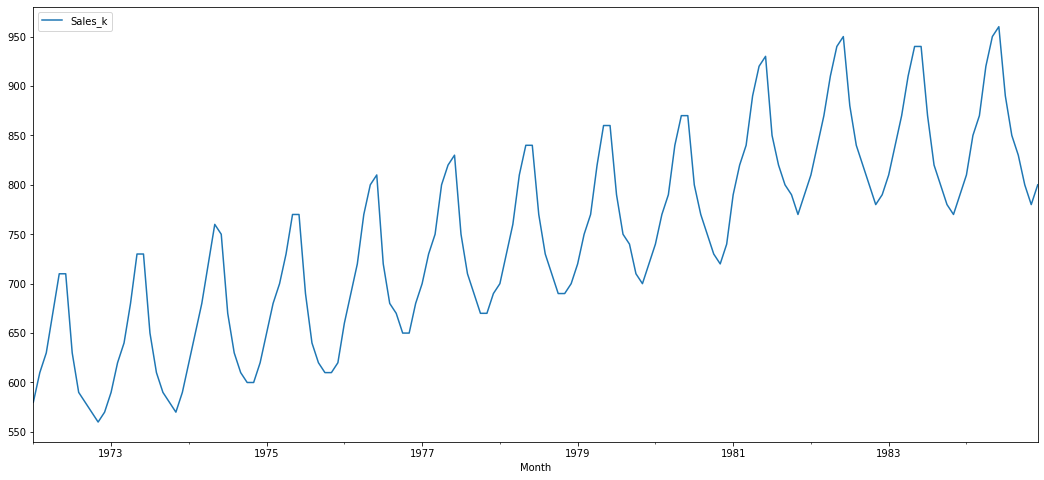

In [5]:
ts.plot_data()

From the plotting of the data itself, we get an idea this time series is not stationary. We will perform different tests on stationarity later. 

# Train Test Split

In [6]:
ts.train_test_split()

test data shape  (7, 1) 

train data shape (149, 1) 



# Stationarity checking

#### We perform Augmented Dickey-Fuller,Phillips-Perron and  KPSS Stationarity Test to evaluate the staionairty of the time series

In [7]:
ts.check_stationarity()

ADF 
    Augmented Dickey-Fuller Results   
Test Statistic                 -1.149
P-value                         0.695
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
PP test 
      Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.235
P-value                         0.194
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
KPSS Test 
     KPSS Stationarity Test Results   
Test Statistic                  1.702
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%),

#### So after performing all three tests and looking at the p_values we come to a conclusion that the time series is not stationary. So we would use difference method to make it stationary. 

# First Order Difference

#### Now we would look at the first order difference of the time series, perform stationarity tests and plot the graph. 


 Order of Difference:  1 

ADF 
    Augmented Dickey-Fuller Results   
Test Statistic                 -3.095
P-value                         0.027
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
PP test 
      Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.078
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
KPSS Test 
     KPSS Stationarity Test Results   
Test Statistic                  0.019
P-value                         0.996
Lags                                3
-------------------------------------

Trend: Constant

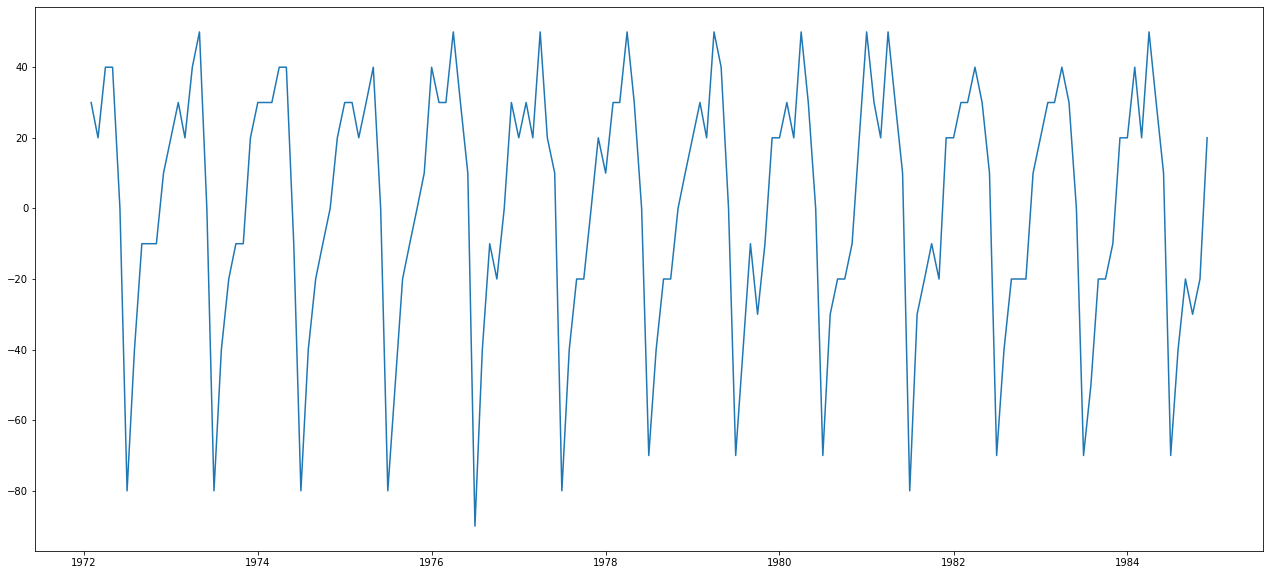

In [8]:
ts.difference(n=1)

#### From all the three tests we can see that the first order difference of the actual time series is stationary. Also the graph tends to indicate that too. So d=1 in our ARIMA Model. 

# ACF and PACF plotting of the original time series

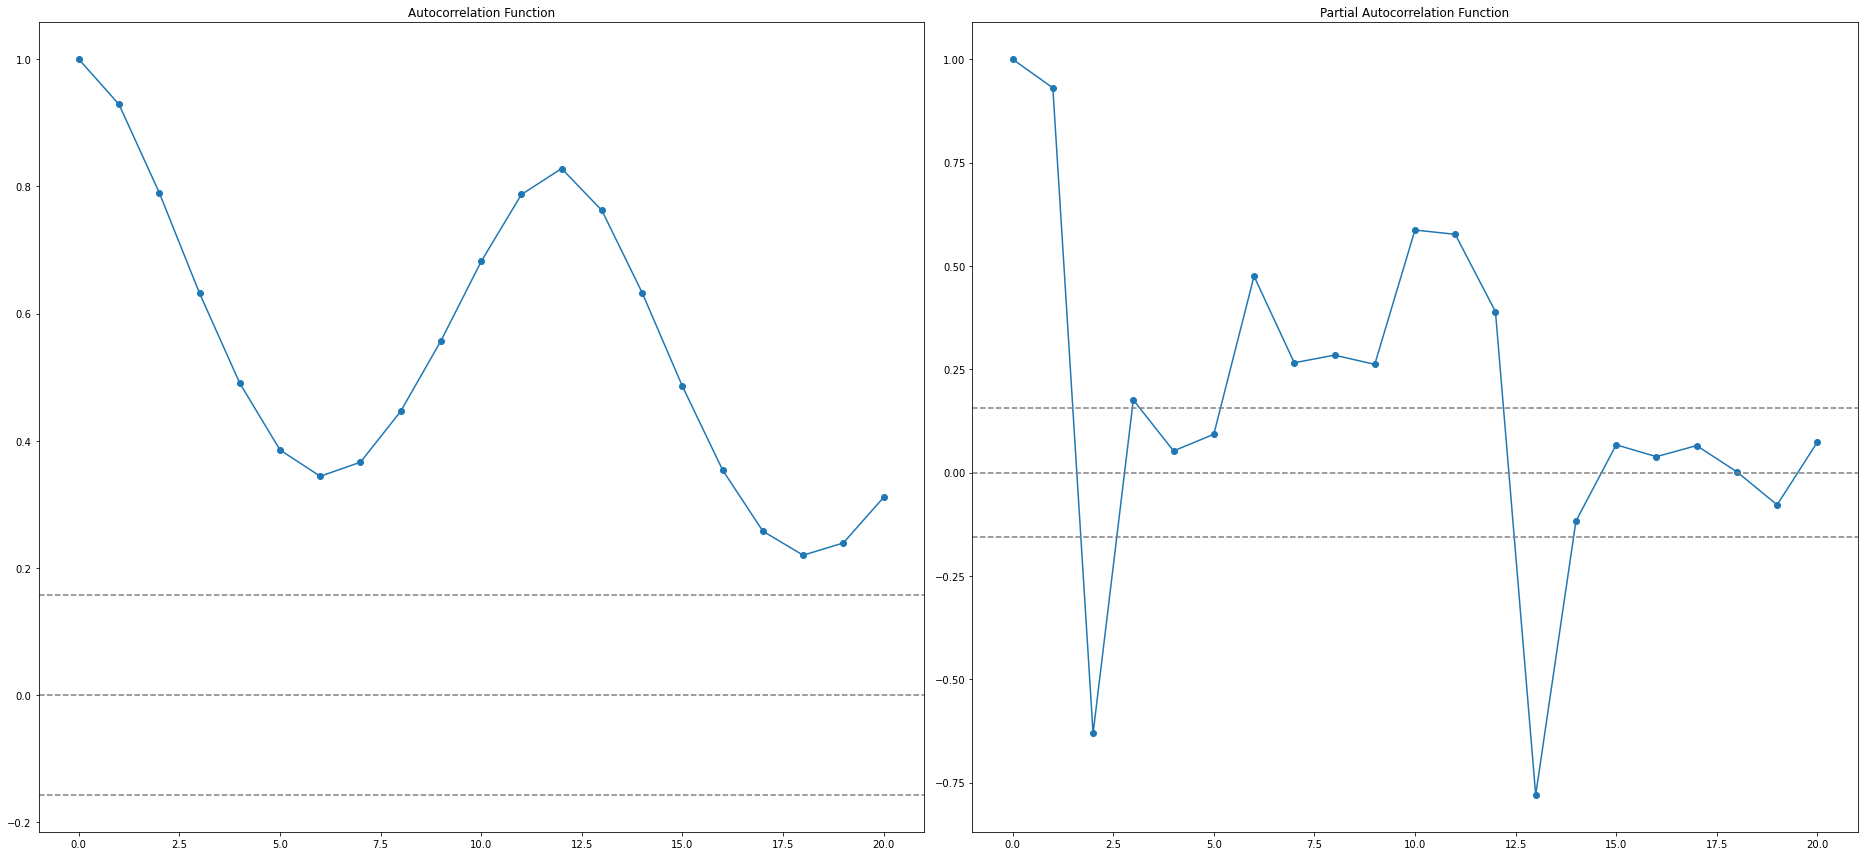

In [9]:
ts.ACF_PACF(difference=0)

# ACF and PACF plottiing of the difference of order 1

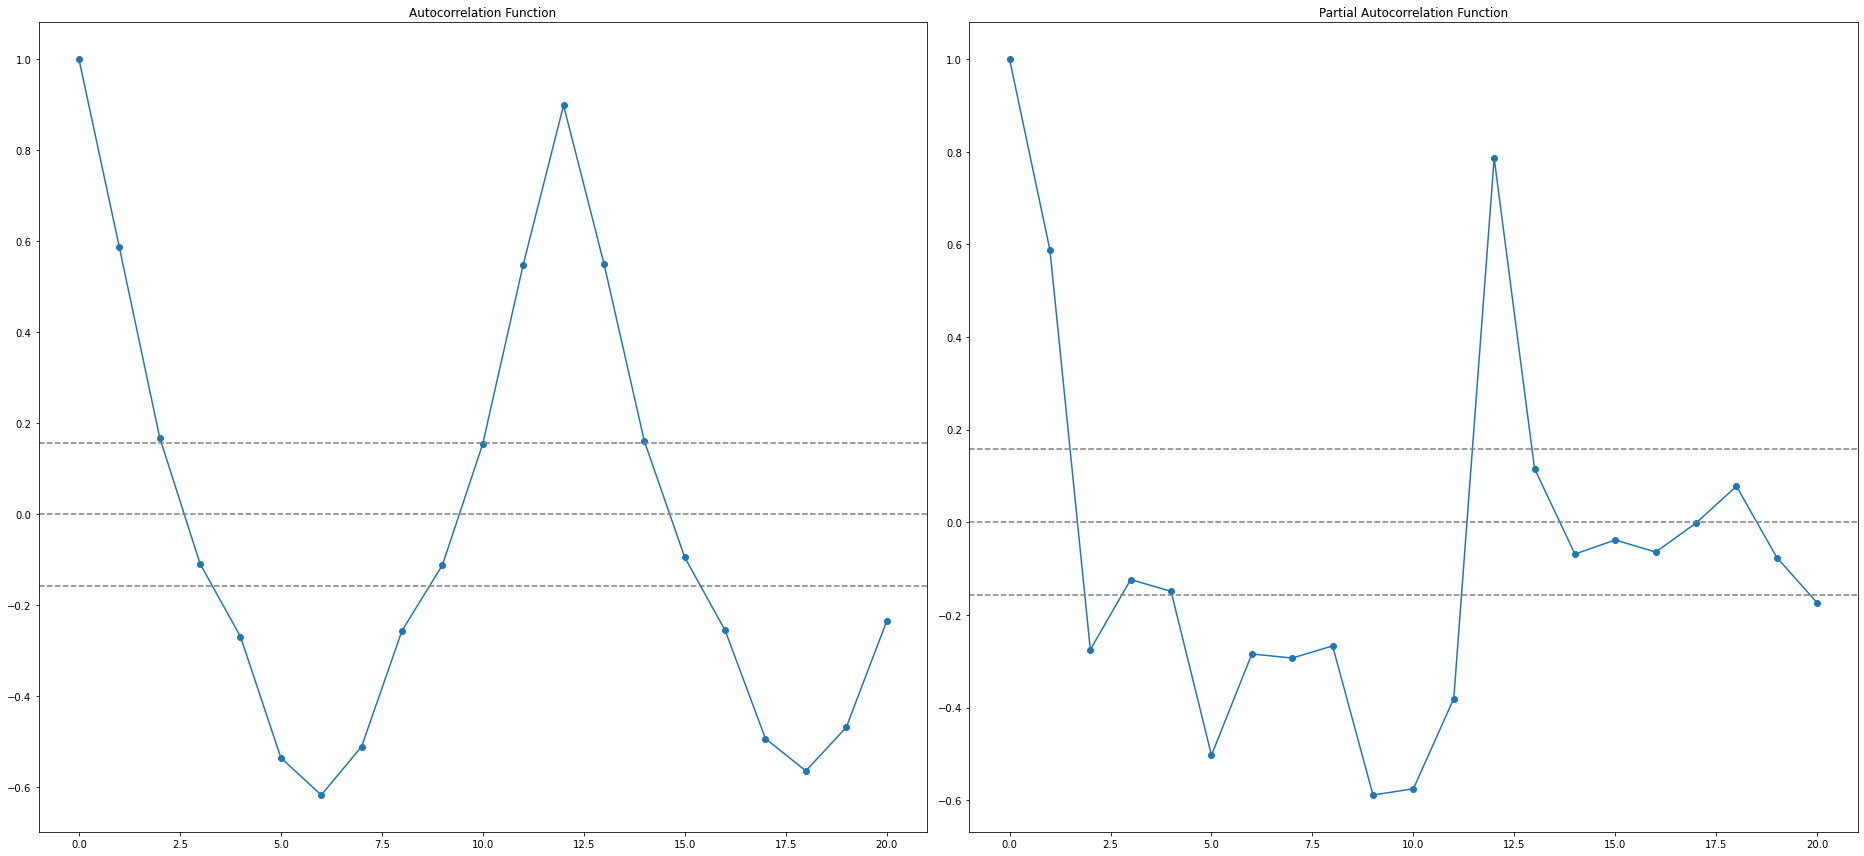

In [10]:
ts.ACF_PACF(difference=1)

# Finding p,q of the ARMA model using AIC

In [11]:
ts.auto_arima(information_criteria='aic')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1466.558, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1540.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1477.200, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1482.866, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1538.989, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1464.559, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1464.672, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1471.279, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1394.938, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1466.648, Time=0

#### so, p=2,d=1(already establihed), and q=3 according to the AIC results

# Finding p,q of the ARMA model using BIC

In [12]:
ts.auto_arima(information_criteria='bic')

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=1484.818, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1546.812, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1486.331, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1491.997, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1542.032, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1479.776, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1476.846, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : BIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1483.452, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=1471.954, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=1487.162, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=1474.890, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : BIC=1481.719, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=1

#### So, p=2,d=1,q=4 from the BIC results

# ARIMA(2,1,3)

C:\Users\ASUS 8I5-8-512-4GTX\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ASUS 8I5-8-512-4GTX\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:              D.Sales_k   No. Observations:                  148
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -645.661
Method:                       css-mle   S.D. of innovations             18.310
Date:                Thu, 04 Nov 2021   AIC                           1305.321
Time:                        13:31:46   BIC                           1326.302
Sample:                    02-01-1972   HQIC                          1313.846
                         - 05-01-1984                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.6038      0.609      2.632      0.008       0.409       2.798
ar.L1.D.Sales_k     1.6975      0.022     77.681      0.000       1.655       1.740
ar.L2.D.Sales_k    -0.9605      

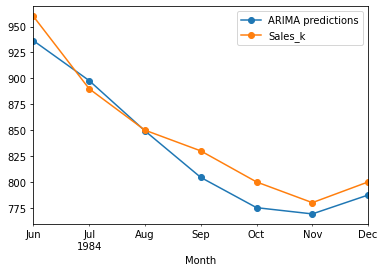

In [13]:
ts.fit_predict(p=2,d=1,q=3)

### MSE(Mean Squared Error)

In [14]:
ts.MSE()

Mean Squared Error:  17.596046627491447
Mean of the test dataset:  844.2857142857143


# ARIMA(2,1,4)

C:\Users\ASUS 8I5-8-512-4GTX\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ASUS 8I5-8-512-4GTX\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:              D.Sales_k   No. Observations:                  148
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -628.357
Method:                       css-mle   S.D. of innovations             16.169
Date:                Thu, 04 Nov 2021   AIC                           1272.714
Time:                        13:31:48   BIC                           1296.692
Sample:                    02-01-1972   HQIC                          1282.456
                         - 05-01-1984                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.7481      0.250      6.994      0.000       1.258       2.238
ar.L1.D.Sales_k     1.7332      0.001   1869.615      0.000       1.731       1.735
ar.L2.D.Sales_k    -0.9999      

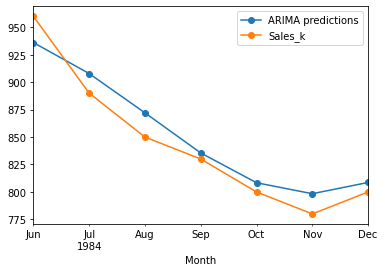

In [15]:
ts.fit_predict(p=2,d=1,q=4)

### MSE (Mean Squared Error)

In [16]:
ts.MSE()

Mean Squared Error:  16.439775948096475
Mean of the test dataset:  844.2857142857143


# Conclusion:

 So, ARMA(2,3) and ARMA(2,4) model of the first order difference [ ARIMA(2,1,3) or ARIMA(2,1,4)] of the time series model is producing good forecast in our case. For both cases Mean Squared Error is very low compared to the mean of the test set and from the graph we can see that the forecast is closely following the actual scenario. So in our time series forecasting we can use either of these two models.  